## Task:

We have two sentences, there are three ways they could be related: 
- one could entail the other (entailment)
- one could contradict the other (contradiction) or
- they could be unrelated (neutral)

Natural Language Inferencing (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related. 

In this notebook, Will explore the [Contradictory, My Dear Watson](https://www.kaggle.com/c/contradictory-my-dear-watson/overview) challange.

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

import plotly.express as px
#px.offline.init_notebook_mode(connected=True)
from IPython.core.display import HTML

from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf

!pip install googletrans
from googletrans import Translator
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import torch
import random


In [ ]:
# directory
DATA_DIR = "/kaggle/input/contradictory-my-dear-watson"

# read train and test csv files
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
#print(f"train data {train_df.shape} test data {test_df.shape}")

In [ ]:
dataset_size = {"train set":train_df.shape[0], "test set":test_df.shape[0]}
fig = px.bar(y = list(dataset_size.keys()), x = list(dataset_size.values()), 
             title="Distribution of train and test", text= list(dataset_size.values()))
fig.update_layout(
    xaxis_title="No of samples",
    yaxis_title="Dataset")
fig.show()

We would be ideally spliting the dataset in ratio of 70-30% or 80-20% for train and test split. Likewise, here also we could see 70-30% split for train and test available already.

We have 17315 samples for train and test. This is descent enough amount of data for any problem. 

In [ ]:
# show list of columns available

html = '<h3>Available columns in the Training data:</h3></br><center><table style="width:50%; border: 1px solid black; "><tr style="border: 1px solid black"><th style="border: 1px solid black">Column name</th><th style="border: 1px solid black">Desc</th></tr>'
cols = train_df.columns.tolist()
cols_desc = ["A unique identifier",
             "Actual sentence",
             "Hypothesis sentence",
             "Language abbreviation code",
             "Language",           
             "Classification of the relationship between the premise and hypothesis (0 for entailment, 1 for neutral, 2 for contradiction)"]
cols_desc = list(zip(cols, cols_desc))
html += " ".join([f"<tr style='border: 1px solid black;'><td style='border: 1px solid black'>{col}<td style='border: 1px solid black'>{desc}</td></tr>" for col, desc in cols_desc])
html += '</table></center>'
display(HTML(html))

Total 7 columns available including with label (target variable). As we could see, the label contains 3 different values that needs to be classified.

Hence, the problem type is **Multi-class classification** since it has more than 2 classes.

The primary input for this challange is:
- premise (Actual sentence)
- hypothesis (Hypothesis sentence)

Also, language code help us to identify what kind of language it contains in our input. Otherise, We would need to identify what kind of language our input contains without this information.


In [ ]:
# show list of languages available

html = '''<head><style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 5px;
  text-align: left;
}
</style></head><body><h3>This dataset contains premise-hypothesis pairs in 15 different languages:</h3></br><center><table style="width:25%"><tr><th>Languages</th><th>Languages code</th></tr>
'''
language_codes = train_df[["language", "lang_abv"]].drop_duplicates().set_index('language').to_dict()["lang_abv"]

html += " ".join([f"<tr><td>{lang}</td><td>{language_codes[lang]}</td></tr>" for lang in language_codes])
html += '</table></center></body>'
display(HTML(html))



Input text contains multiple language. This could be real challanging itself to handle **Multi-lingual** data.

In [ ]:
language_distribution_class = train_df[["id", "language","label"]].groupby(["language","label"])["id"].count().reset_index().rename(columns={"id":"count","label":'class'})
languages_count_dict = language_distribution_class.groupby("language")["count"].sum().to_dict()
# total count of samples for each language
language_distribution_class["total_count"] = language_distribution_class["language"].map(languages_count_dict)
language_distribution_class["percent"] = round(language_distribution_class["count"] / language_distribution_class["total_count"], 2)
language_distribution_class["class_count"] = language_distribution_class["class"].astype(str) + ", "+ language_distribution_class["percent"].astype(str) + "%"
fig = px.pie(language_distribution_class, values='count', names='language',hover_data=["class"], title='Distribution of language of text')
fig1 = px.sunburst(language_distribution_class, path=['language', 'class_count'], values='count', hover_data=["count"], title='Distribution of language with labels')
fig.show()
fig1.show()

There is **56.7%** English text available in which **35%, 32% and 33%** data distributed for each label (0,1, and 2).

Likewise, other language text vary from 3.39% to 2.89% distribution. This is highly unbalanced dataset with respect to each language but we would need to check with the distribution of each labels.

In [ ]:
label_distribution = train_df["label"].value_counts() 
label_distribution.index = ["entailment", "neutral", "contradiction"]

fig = px.bar(label_distribution, title="Label (target variable) distribution")
fig.update_layout(
    xaxis_title="Labels",
    yaxis_title="Frequency")
fig.show()

Label distribution almost balanced for each class.

In [ ]:
stopwords = set(STOPWORDS)

url = "https://raw.githubusercontent.com/amueller/word_cloud/master/examples/a_new_hope.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

wordcloud = WordCloud(stopwords=stopwords, contour_width=3, contour_color='steelblue', background_color="white", max_words=500).generate(",".join(train_df[train_df["language"].str.contains("English")]["premise"].tolist()))
mask = np.array(img)

plt.figure(figsize = (20,15))
plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.title("English word distribution",fontdict={"fontsize":20}, pad=2)
plt.show()

The above Word cloud is for English language. If you make an Word cloud with entire corpus we might see other languages frequency would be very less.

The label (target variable) distribution is close to balanced. Based on the distribution of language is highly different than distribution of each class. 

Hence, we can conclude following observation:
- Multiclass problem
    - 3 classes available to classify
- Multi-lingual
    - Have 15 different languages
- Unbalanced with distribution of language
    - This may cause issue with the lesser vocabulary size in differenct language.

## Tranlate Non-english to English for train and test set.

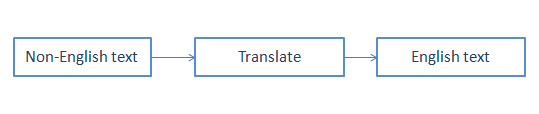

Basic idea is, we have seen there are 15 different languages available in the training data. Hence, doing the experimentation of translating the non-English to English input.

In [ ]:
# instantiate translator
translator = Translator()

# function to translate sentence
def translate_sentence(sentence, src_lang):
    if "en" == src_lang:        
        return sentence
    
    src_lang = "zh-cn" if "zh" in src_lang else src_lang
    translated_sentence = translator.translate(sentence, src=src_lang, dest="en")    
    return translated_sentence.text

def generate_translate_for_other_language():
    ## translation for training data 
    for index, row in tqdm(train_df.iterrows()): 
        # translate premise sentence train set
        train_df.loc[index, "premise_translated"] = translate_sentence(row['premise'], row["lang_abv"])
        # translate hypothesis sentence train set
        train_df.loc[index, "hypothesis_translated"] = translate_sentence(row['hypothesis'], row["lang_abv"])


    file_name = r'translated_text.csv'
    ## save translated dataframe
    train_df.to_csv(file_name, index=False)
    print(f"Translated train dataset saved in {file_name} csv file")
    ## translation for testing data 
    for index, row in tqdm(test_df.iterrows()): 
        # translate premise sentence train set
        test_df.loc[index, "premise_translated"] = translate_sentence(row['premise'], row["lang_abv"])
        # translate hypothesis sentence train set
        test_df.loc[index, "hypothesis_translated"] = translate_sentence(row['hypothesis'], row["lang_abv"])


    file_name = r'translated_test_dataset.csv'
    ## save translated dataframe
    train_df.to_csv(file_name, index=False)
    print(f"Translated train dataset saved in {file_name} csv file")

PROCESSED_OUTPUT_DIR = "../input/my-dear-watson-translated-text"
if os.path.exists(PROCESSED_OUTPUT_DIR):
    train_df[['premise_translated', 'hypothesis_translated']] = pd.read_csv(os.path.join(PROCESSED_OUTPUT_DIR, "translated_train_dataset.csv"))[['premise_translated', 'hypothesis_translated']]
    test_df[['premise_translated', 'hypothesis_translated']] = pd.read_csv(os.path.join(PROCESSED_OUTPUT_DIR, "translated_test_dataset.csv"))[['premise_translated', 'hypothesis_translated']]

print(train_df[train_df["lang_abv"] != 'en'][['premise_translated', 'hypothesis_translated', 'label']].head(3))

## Stratified KFold

In [ ]:
FOLD = 5
k_fold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_df, y=train_df["label"])):
    print(fold, train_idx.shape, val_idx.shape)
    train_df.loc[val_idx,'fold'] = fold

### Let's build Transformer model

In [ ]:
## setting up TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

Input tokens should be tokenized in [CLS] Hello, my dog is cute [SEP] your dog too. [SEP] format.

In [ ]:
def encode_sentence(sentence):
    tokens = list(tokenizer.tokenize(sentence))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
def bert_encoder(hypotheses, premises, tokenizer):
    
    num_examples = len(hypotheses)

    sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

## Augument NLP data

There are various ways that you can do word augument.
- Word embeddings
- TF-IDF
- Contextual Word Embeddings
- Synonym

Will experiment with Synonym augment. Will do substitute the word by **WordNet's synonym**

In [ ]:
!pip install nlpaug
import nlpaug.augmenter.word as naw

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(train_df['premise_translated'][0])
print(f"Orginial: \n{train_df['premise_translated'][0]}\nAugmented Text: \n{augmented_text}")

The above is the sample sentence where augmented a word by **Wordnet** synonym.

Let's randomly augment text for **5% of training data** for each fold. This number is randomly taken.

In [ ]:
## augment text
def agument_text(data_df, col_name):
    aug = naw.SynonymAug(aug_src='wordnet')
    
    for index, row in tqdm(enumerate(data_df[col_name])):
        data_df.loc[index, col_name] = aug.augment(row)
    
    return data_df[col_name]

In [ ]:
max_len = 75

def build_model():
    bert_model = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_model([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

Stratified K-fold model training

In [ ]:
## test set input
test_input = bert_encoder(test_df['premise_translated'].values, test_df['hypothesis_translated'].values, tokenizer) 

## storing prediction results
test_prediction = np.zeros((test_df.shape[0], 3))

## iterate each fold
for fold in range(FOLD):
    train_df_fold = train_df[train_df["fold"] != fold]
    val_df = train_df[train_df["fold"] == fold]
    
    ## agument 5% of training data
    sample_selection = train_df_fold.sample(frac=0.05).reset_index(drop=True)
    
    sample_selection["premise_translated"] = agument_text(sample_selection, "premise_translated")
    sample_selection["hypothesis_translated"] = agument_text(sample_selection, "hypothesis_translated")
    
    train_df_fold = pd.concat([train_df_fold, sample_selection])
    train_input = bert_encoder(train_df_fold['premise_translated'].values, train_df_fold['hypothesis_translated'].values, tokenizer) 
    val_input = bert_encoder(val_df['premise_translated'].values, val_df['hypothesis_translated'].values, tokenizer) 
    
    with strategy.scope():
        model = build_model()
        model.fit(train_input, train_df_fold.label.values, epochs = 6, verbose = 1, batch_size = 64, validation_data = val_input)        
        
        ## predict for unseen data
        predictions = model.predict(test_input)
        
        test_prediction += predictions 
        
## take mean of the prediction
test_prediction = test_prediction / FOLD
## take the maximum probability value 
test_prediction = np.argmax(test_prediction, axis=1)

## Submittion of Predictions

In [ ]:
test_df["prediction"] = test_prediction

In [ ]:
## submission file
test_df[["id", "prediction"]].head()

In [ ]:
test_df[["id", "prediction"]].to_csv("submission.csv", index = False)

#### Thanks for reading the basic exploration notebook with BERT model. 